In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display="diagram")
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_roc_curve, auc,roc_curve,roc_auc_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('Taz_Water.csv')

# A Bit of Data Cleaning

In [3]:
df['funder'].fillna(value='Unknown',inplace=True)
df['funder'].replace(to_replace = '0', value ='Unknown' , inplace=True)

In [4]:
df['installer'].fillna(value='Unknown',inplace=True)  # filling null values with unknown
df['installer'].replace(to_replace = '0', value ='Unknown' , inplace=True) # filling 0 values with unknownb

In [5]:
# From the most common 100 value counts we realized some spelling mistakes or different syntax between same categories

# Replacing the spelling mistakes and collect same categories in same name

df['installer'].replace(to_replace = ('District Water Department', 'District water depar','Distric Water Department'),
                        value ='District water department' , inplace=True)

df['installer'].replace(to_replace = ('FinW','Fini water','FINI WATER'), value ='Fini Water' , inplace=True)
df['installer'].replace(to_replace = 'JAICA', value ='Jaica' , inplace=True)

df['installer'].replace(to_replace = ('COUN', 'District COUNCIL', 'DISTRICT COUNCIL','District Counci', 
                                      'District Council','Council','Counc','District  Council','Distri'),
                                    value ='District council' , inplace=True)

df['installer'].replace(to_replace = ('RC CHURCH', 'RC Churc', 'RC','RC Ch','RC C', 'RC CH','RC church', 
                                      'RC CATHORIC',) , value ='RC Church' , inplace=True)

df['installer'].replace(to_replace = ('Central Government','Tanzania Government',
                                       'central government','Cental Government', 'Cebtral Government', 
                                      'Tanzanian Government','Tanzania government', 'Centra Government' ,
                                      'CENTRAL GOVERNMENT', 'TANZANIAN GOVERNMENT','Central govt', 'Centr', 
                                      'Centra govt') , value ='Central government' , inplace=True)

df['installer'].replace(to_replace = ('World vision', 'World Division','World Vision'),
                                        value ='world vision' , inplace=True)

df['installer'].replace(to_replace = ('Unisef','UNICEF'),value ='Unicef' , inplace=True)
df['installer'].replace(to_replace = 'DANID', value ='DANIDA' , inplace=True)

df['installer'].replace(to_replace = ('villigers', 'villager', 'Villagers', 'Villa', 'Village', 'Villi', 
                                      'Village Council','Village Counil', 'Villages', 'Vill', 'Village community', 
                                      'Villaers', 'Village Community', 'Villag','Villege Council', 'Village council',
                                      'Village  Council','Villagerd', 'Villager', 'Village Technician',
                                      'Village Office','Village community members'),
                                        value ='villagers' , inplace=True)

df['installer'].replace(to_replace =('Commu','Communit','commu','COMMU', 'COMMUNITY') ,
                                        value ='Community' , inplace=True)

df['installer'].replace(to_replace = ('GOVERNMENT', 'GOVER', 'GOVERNME', 'GOVERM','GOVERN','Gover','Gove',
                                      'Governme','Governmen' ) ,value ='Government' , inplace=True)

df['installer'].replace(to_replace = 'Hesawa' ,value ='HESAWA' , inplace=True)

In [6]:
# continue to replacing spellin mistakes and getting together values
df['installer'].replace(to_replace = ('Colonial Government') , value ='Colonial government' , inplace=True)
df['installer'].replace(to_replace = ('Government of Misri') , value ='Misri Government' , inplace=True)
df['installer'].replace(to_replace = ('Italy government') , value ='Italian government' , inplace=True)
df['installer'].replace(to_replace = ('British colonial government') , value ='British government' , inplace=True)
df['installer'].replace(to_replace = ('Concern /government') , value ='Concern/Government' , inplace=True)
df['installer'].replace(to_replace = ('Village Government') , value ='Village government' , inplace=True)
df['installer'].replace(to_replace = ('Government and Community') , value ='Government /Community' , inplace=True)
df['installer'].replace(to_replace = ('Cetral government /RC') , value ='RC church/Central Gover' , inplace=True)
df['installer'].replace(to_replace = ('Government /TCRS','Government/TCRS') , value ='TCRS /Government' , inplace=True)
df['installer'].replace(to_replace = ('ADRA /Government') , value ='ADRA/Government' , inplace=True)

# Unnessary Columns for preditive model

In [7]:
pred_uncol = ['date_recorded','longitude','latitude','wpt_name','num_private','subvillage'
              ,'recorded_by','scheme_name','ward','public_meeting',
             'extraction_type','payment','quality_group','source_type','quantity',
             'waterpoint_type_group','permit']

In [8]:
pred_df = df.drop(pred_uncol,axis=1)
pred_df.head()

,id,amount_tsh,funder,gps_height,installer,basin,region,region_code,district_code,lga,...,extraction_type_class,management,management_group,payment_type,water_quality,quantity_group,source,source_class,waterpoint_type,status_group
0,69572,6000.0,Roman,1390,Roman,Lake Nyasa,Iringa,11,5,Ludewa,...,gravity,vwc,user-group,annually,soft,enough,spring,groundwater,communal standpipe,functional
1,8776,0.0,Grumeti,1399,GRUMETI,Lake Victoria,Mara,20,2,Serengeti,...,gravity,wug,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,34310,25.0,Lottery Club,686,world vision,Pangani,Manyara,21,4,Simanjiro,...,gravity,vwc,user-group,per bucket,soft,enough,dam,surface,communal standpipe multiple,functional
3,67743,0.0,Unicef,263,Unicef,Ruvuma / Southern Coast,Mtwara,90,63,Nanyumbu,...,submersible,vwc,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,non functional
4,19728,0.0,Action In A,0,Artisan,Lake Victoria,Kagera,18,1,Karagwe,...,gravity,other,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,functional


# Setting target to binary

In [9]:
pred_df['status_group'] = pred_df['status_group'].replace('functional needs repair','functional')

# Checking each columns

In [10]:
dd = pred_df.drop('id',axis=1)
dd.isna().sum()

amount_tsh                  0
funder                      0
gps_height                  0
installer                   0
basin                       0
region                      0
region_code                 0
district_code               0
lga                         0
population                  0
scheme_management        3877
construction_year           0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment_type                0
water_quality               0
quantity_group              0
source                      0
source_class                0
waterpoint_type             0
status_group                0
dtype: int64

In [11]:
dd['status_group'].value_counts()

functional        36576
non functional    22824
Name: status_group, dtype: int64

In [12]:
dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   funder                 59400 non-null  object 
 2   gps_height             59400 non-null  int64  
 3   installer              59400 non-null  object 
 4   basin                  59400 non-null  object 
 5   region                 59400 non-null  object 
 6   region_code            59400 non-null  int64  
 7   district_code          59400 non-null  int64  
 8   lga                    59400 non-null  object 
 9   population             59400 non-null  int64  
 10  scheme_management      55523 non-null  object 
 11  construction_year      59400 non-null  int64  
 12  extraction_type_group  59400 non-null  object 
 13  extraction_type_class  59400 non-null  object 
 14  management             59400 non-null  object 
 15  ma

# Train test split

In [13]:
X = dd.drop('status_group',axis=1)
y = dd['status_group']

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# fixing the missing data

## Train

In [15]:
X_train["scheme_management"].fillna("VWC", inplace = True)
X_train['construction_year'] = X_train['construction_year'].replace(0,np.nan)
X_train['construction_year'] = X_train['construction_year'].apply(lambda x: x if pd.notnull(x) else np.random.randint(2000, 2010))

## Test

In [16]:
X_test["scheme_management"].fillna("VWC", inplace = True)
X_test['construction_year'] = X_test['construction_year'].replace(0,np.nan)
X_test['construction_year'] = X_test['construction_year'].apply(lambda x: x if pd.notnull(x) else np.random.randint(2000, 2010))

# Pipe lines

In [17]:
cat_cols = X_train.select_dtypes('object').columns
num_cols = X_train.select_dtypes(['int','float']).columns


numeric_pipe = Pipeline([('numnorm',StandardScaler())])

nominal_pipe = Pipeline([
    ('onehotenc', OneHotEncoder(sparse=False, handle_unknown = 'ignore')),
    ('onehotnorm', StandardScaler())
])

In [18]:
ct = ColumnTransformer([
    ('numpipe',numeric_pipe, num_cols),
    ('nominalpipe',nominal_pipe,cat_cols),
])
ct

ColumnTransformer(transformers=[('numpipe',
                                 Pipeline(steps=[('numnorm',
                                                  StandardScaler())]),
                                 Index(['amount_tsh', 'gps_height', 'region_code', 'district_code',
       'population', 'construction_year'],
      dtype='object')),
                                ('nominalpipe',
                                 Pipeline(steps=[('onehotenc',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False)),
                                                 ('onehotnorm',
                                                  StandardScaler())]),
                                 Index(['funder', 'installer', 'basin', 'region', 'lga', 'scheme_management',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment_type', 'water_quality', 'quantity_group',
       'source', 'source_class', 'waterpoint_type'],
      dtype='object'))])

In [19]:
xg = Pipeline([
    ('preprocess', ct),
    ("smote", SMOTE(random_state=42)),
    ('model',XGBClassifier(random_state=42,max_depth=3))
])
xg

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['amount_tsh', 'gps_height', 'region_code', 'district_code',
       'population', 'construction_year'],
      dtype='object')),
                                                 ('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('onehotnorm',
                                                                   Stand...
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=None, subsample=None,
                               tree_method=None, validate_parameters=None,
                               verbosity=None))])

# Fit the Model

In [20]:
xg.fit(X_train,y_train)
y_pred = xg.predict(X_test)

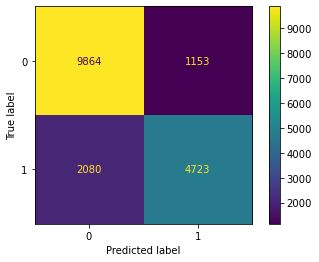

In [21]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm
                              )
disp.plot();

In [22]:
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

    functional       0.83      0.90      0.86     11017
non functional       0.80      0.69      0.75      6803

      accuracy                           0.82     17820
     macro avg       0.81      0.79      0.80     17820
  weighted avg       0.82      0.82      0.82     17820



# Checking is overfitting

In [23]:
print(xg.score(X_train,y_train))
print(xg.score(X_test,y_test))

0.8246031746031746
0.8185746352413019


# AUC

In [24]:
from sklearn.metrics import roc_auc_score

y_score = xg.fit(X_train, y_train).predict_proba(X_test)



micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score[:, 1],
)

In [25]:
micro_roc_auc_ovr

0.8836539766406203

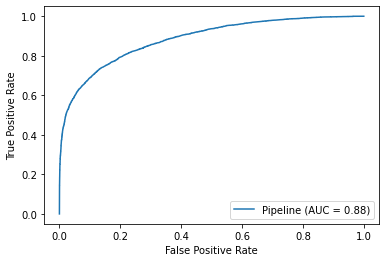

In [26]:
plot_roc_curve(xg,X_test,y_test);

# Random Search

In [27]:

from sklearn.model_selection import RandomizedSearchCV

params = {'model__max_depth': [3,4, 5], 'model__learning_rate': [.05, .1, .3, .5],
          'model__gamma': [0,5,10], 'model__colsample_bynode': [.5, .75, 1],
          'model__n_estimators': [50,100,150] }

params

{'model__max_depth': [3, 4, 5],
 'model__learning_rate': [0.05, 0.1, 0.3, 0.5],
 'model__gamma': [0, 5, 10],
 'model__colsample_bynode': [0.5, 0.75, 1],
 'model__n_estimators': [50, 100, 150]}

In [28]:
cv = RandomizedSearchCV(estimator = xg,
                  param_distributions= params,
                       n_iter =50,random_state = 42)
cv

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('numpipe',
                                                                               Pipeline(steps=[('numnorm',
                                                                                                StandardScaler())]),
                                                                               Index(['amount_tsh', 'gps_height', 'region_code', 'district_code',
       'population', 'construction_year'],
      dtype='object')),
                                                                              ('nominalpipe',
                                                                               Pipeline(steps=[('onehotenc',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              spars...
                                                            num_parallel_tree=1,
                                                            random_state=42,
                                                            reg_alpha=0,
                                                            reg_lambda=1,
                                                            scale_pos_weight=1,
                                                            subsample=1,
                                                            tree_method='exact',
                                                            validate_parameters=1,
                                                            verbosity=None))]),
                   n_iter=50,
                   param_distributions={'model__colsample_bynode': [0.5, 0.75,
                                                                    1],
                                        'model__gamma': [0, 5, 10],
                                        'model__learning_rate': [0.05, 0.1, 0.3,
                                                                 0.5],
                                        'model__max_depth': [3, 4, 5],
                                        'model__n_estimators': [50, 100, 150]},
                   random_state=42)

In [29]:
# cv.fit(X_train,y_train)

In [30]:
# cv.best_params_

In [31]:
# cv.best_score_

In [32]:
# from joblib import dump, load
# dump(cv.best_params_, 'XGB_best_params.joblib') 

In [33]:
from joblib import dump, load
clf = load('XGB_best_params.joblib')
clf

{'model__n_estimators': 150,
 'model__max_depth': 5,
 'model__learning_rate': 0.5,
 'model__gamma': 5,
 'model__colsample_bynode': 0.75}

# Best Model

In [34]:
best_model = Pipeline([
    ('preprocess', ct),
    ("smote", SMOTE(random_state=42)),
    ('model',XGBClassifier(random_state=42,
                           max_depth = clf['model__max_depth'], learning_rate = clf['model__learning_rate'],
                           gamma = clf['model__gamma'], colsample_bynode = clf['model__colsample_bynode'],
                          n_estimators = clf['model__n_estimators']))
])
best_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['amount_tsh', 'gps_height', 'region_code', 'district_code',
       'population', 'construction_year'],
      dtype='object')),
                                                 ('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('onehotnorm',
                                                                   Stand...
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.5,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=150,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=None, subsample=None,
                               tree_method=None, validate_parameters=None,
                               verbosity=None))])

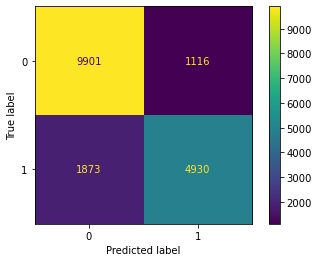

In [35]:
best_model.fit(X_train,y_train)
best_y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, best_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm
                              )
disp.plot();

# Best Model Accuracy

In [36]:
print(best_model.score(X_test,y_test))

0.832267115600449


In [37]:
print(classification_report(y_test, best_y_pred))

                precision    recall  f1-score   support

    functional       0.84      0.90      0.87     11017
non functional       0.82      0.72      0.77      6803

      accuracy                           0.83     17820
     macro avg       0.83      0.81      0.82     17820
  weighted avg       0.83      0.83      0.83     17820



# Best Model AUC

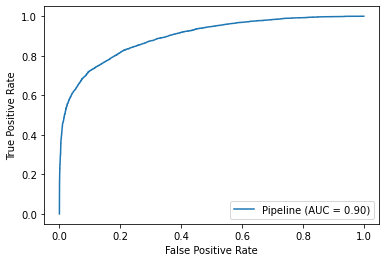

In [39]:
plot_roc_curve(best_model,X_test,y_test);